# Statistical modelling club performance analysis

In 2019, as a member of the club committee for Southampton based running club Lordshill Road Runners (LRR), I decided to conduct a population analysis of club members in order to investigate the ideal training group boundaries for the club. Weekly training groups set these boundaries based on 5k performance, such that a runner can move between groups based on their present 5k ability.

The basis of this analysis is formed from 5k times recorded by club runners at the local parkrun event, Southampton parkrun. parkrun offers free 5k events globally every Saturday, and is exceptionally popular in Southampton, often drawing over 1000 partipents per week. parkrun results are recorded such that all historical data are publicly accessible. LRR club runners had recorded >20,000 parkrun times at Southampton parkrun by mid-2019 alone.

This notebook takes the times of all LRR club members up to mid-2019, using this sample of recorded 5k times as a proxy for performance at weekly training sessions. It explores methods such as web scraping, statistical modelling (with MCMC methods), model selection and integration, in order to suggest where idealised group boundaries should be set.

This analysis makes several big assumptions: namely that parkrun performance ties with overall ability -- which may fall down if runners choose to run their parkruns at an easy pace (although this may also be true for their traning). Moreover, in assuming all parkrun times by runners to be unweighted and equal, it introduces a bias weighted towards those club runners who complete Southampton parkruns more often, without a gauge as to how often they attend training. Given these working assumptions, I walk through my methodology in this notebook and show how this dataset proves a useful test case for many techniques I employ here.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.integrate import quad

import requests
import bs4
import emcee
import corner

# How to web scrape in python (and when you should)

Web scraping is the ideal method for extracting information from webpages using an automated procedure. This can be done fairly trivially in python, with the use of a couple of libraries. If conducted on a large scale web scraping can glean huge datasets with relatively minimal computational expenditure. At this level, it is useful for extracting publicly accessible data in an efficient manner.

There are some ethical quandaries related to scraping however. As a rule of thumb it is important to ensure that a scraper does not overwhelm a server with requests (which can sometimes result in a short term IP address ban if triggered) and that any extracted data are licensed for public or personal use. 

I introduce a simple example of a scraper below, written in python and using both the 'requests' and 'Beautiful Soup' packages. The webpage in question displays the results of the July 2021 edition of the Lakeside 5k road race series, which is a long-running annual series of 5k races held near Portsmouth, in the UK. The scraper identifies the results table and successfully loads this into a pandas dataframe, should we then want to analyse these results.

In [2]:
# First, define the url of the page which we want to scrape data from
url = "https://www.portsmouthathletic.co.uk/siteglide-blog/lakeside-5k-21-july-2021"

# Now use the requests library to return a response from this url
response = requests.get(url)

# And now employ the Beautiful Soup (BS) python package to parse the html code for data extraction
soup = bs4.BeautifulSoup(response.text)

# We can use the 'find all' method in BS to identify the table of results
tables = soup.find_all("table")

# In this case there is only a single table so we can simplify this:
table = tables[0]

# We need to decode the html text and can do so in pandas to return a list, containing a dataframe
df = pd.read_html(table.decode())[0]

# We can now re-form the results table from the url into an equivalent pandas dataframe
df.columns = df.iloc[0]  # Identify the columns in the first row and set as new names
df = df[1:]  # Remove redundant first row

# Which returns this dataframe:
df.head()

,No,Pos,Time,First Name,Last Name,Age Cat,Club
1,51,1,14:53,Ben,Brown,U17M,Southampton A.C.
2,90,2,15:33,Paul,Navesey,SM,City of Portsmouth A.C.
3,136,3,15:41,Rob,Wood,SM,Basingstoke & Mid Hants A.C.
4,140,4,15:56,James,Baker,VM40,Chichester Runners & A.C.
5,50,5,16:36,Tom,Cully,SM,Southampton A.C.


Naturally, this method needs to be adjusted depending on the exact nature of the html output (e.g. the number of tables), and updated should the webpage change.

In the case of this notebook however, we're interested not in an individual race, but in a larger dataset of 5k results. parkrun, the worldwide 5k phenomenon, has publicly available data hosted at https://www.parkrun.com/. However, parkrun have a policy prohibiting the scraping of data from their webpages, see https://www.parkrun.com/scraping/. Hence, we *cannot* implement this scraping method here and I do not advocate it. parkrun's policy is that their data are copyrighted, and may be used only in personal cases (as is the case here); not for commercial reasons. This notebook is motivated purely out of academic curiosity and data enthusiasm.

Luckily, it is fairly trivial in this case to access times manually for individual athletes and copy these values into a spreadsheet, which can then be trivially read and saved using python. Here, I load in a pre-made numpy file containing times of LRR club runners at Southampton parkrun, up to mid-2019. Names and all other information are removed for confidentiality. If using this notebook for yourself, simply load in your own data and experiment with the outputs! 

## parkrun times

In [3]:
# Let's load in the numpy file of parkrun times
parkrun_times = np.load("/Users/dia1u17/Desktop/DataWork/Running_Projects/mini_project/parkrun_times.npy")

In [4]:
# The first 10 times look like this:
parkrun_times[:10]

array(['16:02', '19:40', '15:47', '16:45', '17:52', '17:07', '18:17',
       '16:48', '17:53', '16:24'], dtype='<U7')

In [5]:
# Let's convert these strings into floats and from minutes to seconds
times_parkrun = []

for i in parkrun_times:

    split = i.split(":")  # Split on ":""
    
    if len(split) < 3:  # If time is in XX:XX format
        time = float(split[0])*60 + float(split[1])  # Convert minutes to seconds
        times_parkrun.append(time)
    elif len(split) == 3:  # If time is in XX:XX:XX format
        time = float(split[0])*3600 + float(split[1])*60 + float(split[2])  # Convert minutes to seconds
        times_parkrun.append(time)    

In [6]:
# The first 10 times now look like this:
times_parkrun[:10]

[962.0, 1180.0, 947.0, 1005.0, 1072.0, 1027.0, 1097.0, 1008.0, 1073.0, 984.0]

In [7]:
# Some summary statistics of the parkrun data:

def secs_mins(time):
    "Function to convert seconds (floats) back into strings mins:seconds"
    
    mins = int(time/60)    
    secs = 60*(time/60 - int(time/60))
    
    round_secs = round(secs,0)  
    if round_secs < 10:  # Ensures any :0X seconds is displayed as such
        round_secs = '0{}'.format(round_secs)
    
    return '{0}:{1}'.format(mins, round_secs)


mean = np.mean(times_parkrun)
print('Mean time: ', secs_mins(mean))

median = np.median(times_parkrun)
print('Median time: ', secs_mins(median))

std_dev = np.std(times_parkrun)
print('Std dev time: ', secs_mins(std_dev))

fastest_time = np.min(times_parkrun)
print('Fastest time: ', secs_mins(fastest_time))

slowest_time = np.max(times_parkrun)
print('Slowest time: ', secs_mins(slowest_time))

Mean time:  26:40.0
Median time:  26:06.0
Std dev time:  5:25.0
Fastest time:  15:47.0
Slowest time:  69:24.0


# Statistical modelling (using an MCMC)

Now we have a handle on our parkrun data, let's try to understand the underlying nature of it through some statistical modelling. I will first visualise the sample distribution with a histogram, before defining a simple model and conducting an initial statistical fit using scipy.optimize curve_fit. I then proceed to use MCMC sampling on these data (using emcee), not out of strict necessity, but as a useful example of how to implement this methodology and more advanced metrics we can then obtain from it.

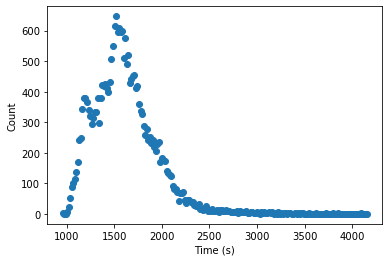

In [8]:
# Let's bin up these parkrun times into a histogram
hist_parkrun = np.histogram(times_parkrun, bins=200)  # Of 200 bins

x_parkrun = hist_parkrun[1][:-1]+(hist_parkrun[1][1]-hist_parkrun[1][0])/2  # Reset x bin centre
y_parkrun = hist_parkrun[0]
yerr_parkrun = hist_parkrun[0]*0 + 5  # Assume a uniform 5 second error across all times 

plt.xlabel('Time (s)')
plt.ylabel('Count')

# Let's see what the distribution of times looks like:
plt.scatter(x_parkrun , y_parkrun)

plt.show()

The distribution looks approximately lognormal. This is not a surprise, as a lognormal is a common descriptor of many human behaviours and natural processes (e.g. in X-ray astronomy, the lognormal flux distribution). It is produced in cases where *multiplicative* effects act on a sample, exactly analogous to the *additive* effects which create a normal distribution through the Central Limit Theorem (CLT). Through the Multiplicative CLT, multiplicative effects tend a sample which is normal in logspace (recall how log(ab) = log(a) + log(b) to see how this works). This process creates a lognormal distribution.

We can therefore choose to model these data starting with a simple lognormal distribution. It appears however that there are other features in the data, including a possible secondary peak around ~1200 seconds, which we investigate later in this notebook.

## Using scipy.optimize curve_fit

There are a number of minimisation algorithm python packages available to model data like this. curve_fit offers an easy starting point in model fitting, and by default implements the Levenberg-Marquardt algorithm through a least-squares method. This is not a one-size-fits-all method (e.g. least squares methods assume uniform, Gaussian errors) and can be slow/requires a good choice of initial parameters, but we can use it here to set-up our MCMC. 

## Lognormal model

In [9]:
# Let's start by defining a lognormal distribution
def log_normal(x, a1, b1, c1):
    """Returns a lognormal distribution"""
    G = a1*np.exp( -(np.log10(x)-b1)**2  / (2*(10**c1)**2) )
    return G

# Where: a1 = peak height, b1 = log_10(centre of peak), c1 = log_10(standard deviation)

In [10]:
# And use scipy curve_fit minimisation algorithm to find a global minimum (using a good choice of initial params p0)
popt, pcov = curve_fit(log_normal, x_parkrun, y_parkrun, p0=[80,3,-1.25], sigma=yerr_parkrun)

# Print optimised parameters a1, b1, c1 
print(popt)

[526.57628497   3.17789294  -1.08265704]


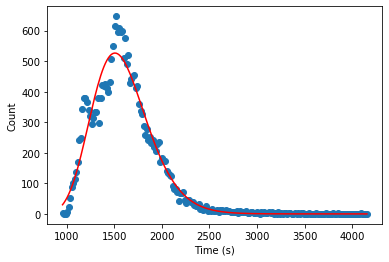

In [11]:
# The best fit with this model using curve_fit looks like this:
plt.scatter(x_parkrun, y_parkrun)
plt.plot(x_parkrun, log_normal(x_parkrun, *popt), color='red')

plt.xlabel('Time (s)')
plt.ylabel('Count')

plt.show()

This is a decent start, but certainly this model is not a fantastic descriptor of the data. curve_fit is a useful tool for initial exploration, but is limited in scope when it comes to non-linear least squares/non-Gaussian fitting and error determination.

To understand the nature of the model parameters better we can employ Bayesian methods. In fact, a Bayesian methodology requires a fundamental overhaul in statistical philosophy, a discussion about which is well beyond the scope of this notebook, but a textbook I found very helpful in covering these topics (from outline -- to understanding priors/likelihoods/posteriors -- to MCMC methods) is Ben Lambert's "A Student's Guide to Bayesian Statistics", and I recommend it highly.

Here, I assume a basic level of Bayesian statistics knowledge is known to the reader, including the role of MCMC methods as a dependent sampler. As aforementioned, this application is not strictly essential to complete the initial aim, but shows a simple example of how to implement these methods, visualise outputs and apply model selection statistics.

## emcee (MCMC) modelling 

For this implementation of MCMC sampling I use the 'emcee' python package. For the emcee docs, see: https://emcee.readthedocs.io/en/stable/tutorials/quickstart/ 

In [12]:
# Let's define our emcee functions: likelihood, prior and log_probaility, as adapted from the emcee docs
# All for our lognormal distribution

def log_likelihood(theta, x, y, yerr):
    "Function returns the log likelihood: log[p(x|theta)]"
    
    a1, b1, c1, log_f = theta  # Defined parameters
    model = log_normal(x, a1, b1, c1)
    sigma2 = yerr**2 + model**2*np.exp(2*log_f)
    
    return -0.5*np.sum((y-model)**2/sigma2 + np.log(sigma2))


def log_prior(theta):
    "Function defining the priors: p(theta)"
    
    a1, b1, c1, log_f = theta
    if 20 < a1 < 1000 and 2.5 < b1 < 4 and -3 < c1 < 1 and -15 < log_f < 10:  # Uniform prior, with set boundaries      
        return 0.0
    
    return -np.inf


def log_probability(theta, x, y, yerr):
    "Function returning the log probability: log[p(theta|x)]"
    
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + log_likelihood(theta, x, y, yerr)


In [13]:
# Let's set up the MCMC sampler in emcee and then launch it

nwalkers, ndim = 100, 4  # Define a number of walkers (100) and number of dimensions (4: a1, b1, c1 & log(f))

p0 = np.array([*popt,-10])  # Use curve_fit parameters as starting positions
pos = p0 + 1e-4*np.random.randn(nwalkers,ndim)  # Randomise starting position of walkers

# Now define the MCMC sampler, using the defined log_probability function and data as arguments
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x_parkrun, y_parkrun, yerr_parkrun))

# Set the number of steps to be 10,000 and run the MCMC (takes ~50 seconds)
sampler.run_mcmc(pos, 10000, progress=True)

100%|██████████| 10000/10000 [00:47<00:00, 209.26it/s]


State([[538.52851571   3.17623534  -1.09272022  -1.37965134]
 [482.29994575   3.17450026  -1.07649863  -1.45684381]
 [507.44310201   3.1754796   -1.08473367  -1.48478803]
 [496.70134937   3.17826914  -1.07902535  -1.27714644]
 [503.42083979   3.17281529  -1.07423432  -1.3353987 ]
 [537.36713501   3.17720915  -1.0934135   -1.45682743]
 [513.74615632   3.17422917  -1.08544747  -1.32946834]
 [489.55040108   3.17765465  -1.08445722  -1.25472786]
 [518.53936355   3.17362172  -1.07840702  -1.36728013]
 [525.88479785   3.17490368  -1.09413019  -1.3474574 ]
 [527.63061746   3.17484047  -1.07841016  -1.43216783]
 [508.24943857   3.17297712  -1.06895051  -1.4197922 ]
 [527.77078482   3.17603433  -1.08597753  -1.47648036]
 [541.52459354   3.17652976  -1.08879331  -1.30674865]
 [476.43715404   3.17317833  -1.066732    -1.35691843]
 [511.91058812   3.17404278  -1.08170838  -1.35430283]
 [508.9161526    3.17377479  -1.08254796  -1.49869671]
 [546.75442258   3.17376405  -1.07393885  -1.45796475]
 [54

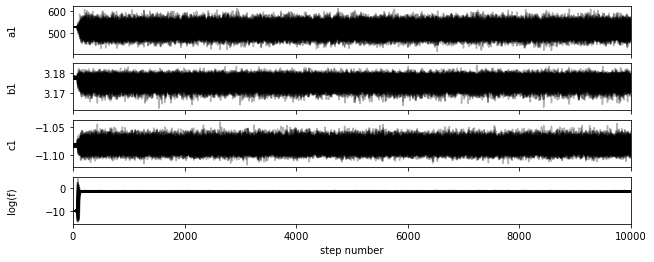

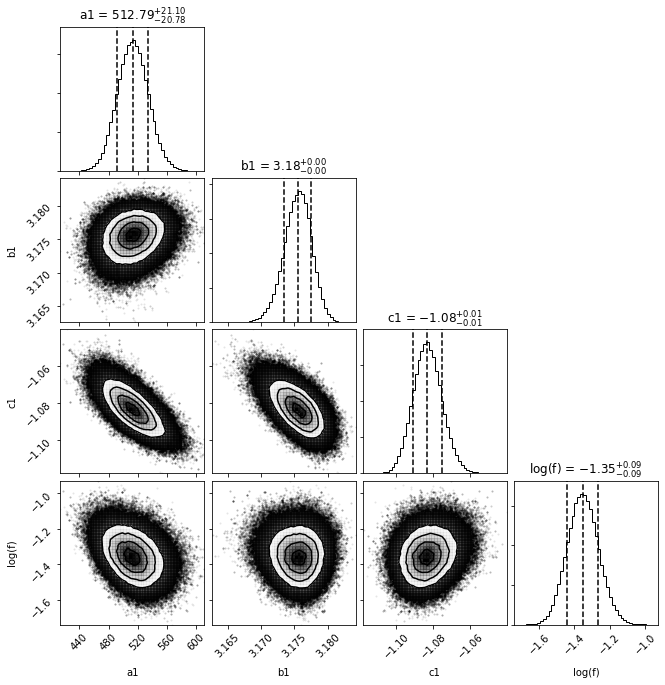

In [14]:
# Let's visualise our chains (a good method to check convergence)

fig, axes = plt.subplots(ndim, figsize=(10, 4), sharex=True)
samples = sampler.get_chain()  # Retrieve samples
labels = ["a1", "b1", "c1", "log(f)"]  # Parameter labels

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

# Plot chains, where we're looking for a noisy, stochastic ("hairy caterpiller") output (after burn-in)
flat_samples = sampler.get_chain(discard=1000, flat=True)  # Discard the first (burn-in) 1,000 samples 

# Plot the corner plot comparing each parameter over 1 sigma error contours
corner.corner(flat_samples,labels=labels,quantiles=[0.16,0.5,0.84], show_titles=True, bins=50)

plt.show()

These marginalised posteriors are looking good! 

The chains burn in after 100-200 steps, and converge nicely. The corner plot shows well constrained parameter contours, with a clear global minimum for each.

In [15]:
# Let's obtain our parameter solutions from the chains, using our 1 sigma error quantiles, and map these to a function
# which calculates these over our samples:
a1_sol, b1_sol, c1_sol, f_sol = \
map(lambda v: (v[1],v[2]-v[1],v[1]-v[0]), zip(*np.percentile(flat_samples,[16,50,84],axis=0)))

mod1_params = a1_sol[0], b1_sol[0], c1_sol[0]  # The model fit parameters

# Which returns the solutions:
print('emcee: ', *mod1_params)

# Which are very similar to the curve_fit solutions (as hoped/expected)
print('curve_fit: ', *popt)

emcee:  512.7880317361078 3.175519642506175 -1.0833015766474021
curve_fit:  526.5762849738235 3.177892940557699 -1.0826570426871756


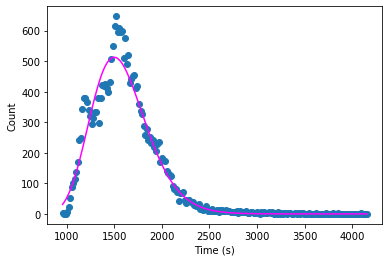

In [16]:
# For confirmation, the emcee fit looks like this:
plt.scatter(x_parkrun, y_parkrun)
plt.plot(x_parkrun, log_normal(x_parkrun, *mod1_params), color='magenta')

plt.xlabel('Time (s)')
plt.ylabel('Count')

plt.show()

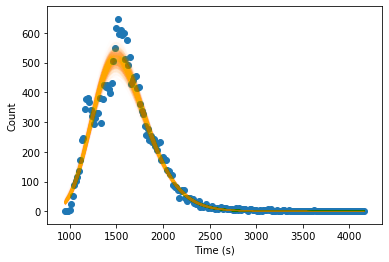

In [17]:
# We can overlay a sample of 1000 chains to show a distribution of model fits:
inds = np.random.randint(len(flat_samples), size=1000)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x_parkrun, log_normal(x_parkrun, *sample[:-1]), color='orange', alpha=0.01)
    
plt.scatter(x_parkrun, y_parkrun)

plt.xlabel('Time (s)')
plt.ylabel('Count')

plt.show()

In [18]:
# More precisely, we can calculate and show the 1 sigma credible intervals (i.e. 68% probability the true model lies
# within this range) using the results from the MCMC. We have already determined the necessary percentiles:

mod1_upp = a1_sol[1], b1_sol[1], c1_sol[1]  # The [84th percentile - median] parameter values
mod1_low = a1_sol[2], b1_sol[2], c1_sol[2]  # The [median - 16th percentile] parameter values

mod1_uppsig = np.array(mod1_upp) + np.array(mod1_params)  # The +1 sigma parameters (added with np arrays)
mod1_lowsig = np.array(mod1_params) - np.array(mod1_low)  # The -1 sigma parameters


# Note, we could equivalently used this loop method on the chain samples directly, but is less efficient:

lines = [log_normal(x_parkrun, a1, b1, c1) for a1, b1, c1, f in flat_samples]
std_dev = np.std(lines, axis=0)  # Use the standard deviation on the median parameters for error ranges

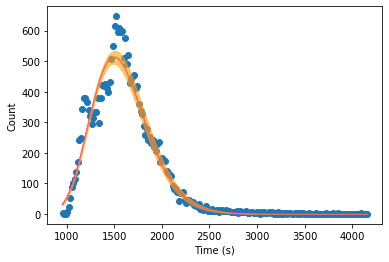

In [19]:
# We can now plot the model output with 68% credible intervals (error contours)

fig, ax = plt.subplots()

ax.scatter(x_parkrun, y_parkrun)

ax.fill_between(x_parkrun, log_normal(x_parkrun, *mod1_uppsig), log_normal(x_parkrun, *mod1_lowsig), 
                color='orange', zorder=3, alpha=0.6)  # Input the +1/-1 sigma parameters

ax.plot(x_parkrun, log_normal(x_parkrun, *mod1_params), color='magenta')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Count')

plt.show()

Excellent! We have taken our basic model and obtained both a 'best fit' and error ranges with emcee. We can see however that this simple model is limited in scope in describing the underlying distribution of the data. The next step is to introduce a more complex model, perform the same procedural tests, before comparing the models statistically.

## Lognormal + Gaussian model

Let's introduce an additional component into the basic model, and follow a similar procedure to the above.

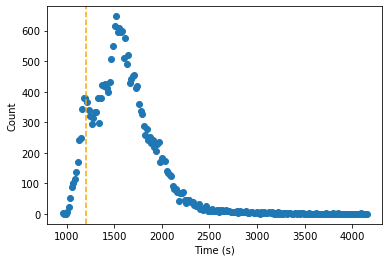

In [20]:
# Clearly there is a secondary peak in the data around 1200 seconds (20 mins):
plt.xlabel('Time (s)')
plt.ylabel('Count')

plt.scatter(x_parkrun , y_parkrun)

# Plot a line at 1200s/20 mins
plt.axvline(60*20, color='orange', linestyle='--')

plt.show()

This feature corresponds exactly to a cluster of times around the 20 minute mark. This is likely an artificial bias corresponding to the 20 minute target, which takes the form of a good target as both a challenge for aspiring club runners, or as an easy/tempo pace, for experienced racers. 

In [21]:
# Let's create a more complex model which combines this same lognormal with an additional Gaussian distribution
# defined with a frozen paramerer b2 = 1200 (i.e. fixed and centred on 20 mins) 

def log_normal_gauss(x, a1, b1, c1, a2, c2):
    """Returns lognormal distribution + Gaussian distribution, mean = 1200"""
    G = a1*np.exp( -(np.log10(x)-b1)**2  / (2*(10**c1)**2) ) + a2*np.exp( -(x-1200)**2  / (2*(10**c2)**2) )
    return G

# Where: a1 = lognormal peak height, b1 = log_10(centre of lognormal), c1 = log_10(lognormal standard deviation)
# a2 = Gaussian peak height, c2 = Gaussian standard deviation

In [22]:
# Let's implement this new model as before using scipy curve_fit and some well chosen initial parameters
popt2, pcov2 = curve_fit(log_normal_gauss, x_parkrun, y_parkrun, p0=[100,3,-1.2,80,0.1], sigma=yerr_parkrun)

# Print optimised parameters a1, b1, c1, a2, c2
print(popt2)

[539.47979213   3.19236395  -1.16518118 226.49763169   1.8121909 ]


/Users/dia1u17/opt/anaconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


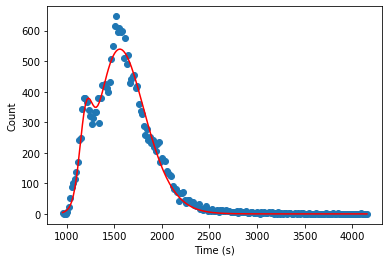

In [23]:
# The best fit with this revised model using curve_fit looks like this:
plt.scatter(x_parkrun, y_parkrun)
plt.plot(x_parkrun, log_normal_gauss(x_parkrun, *popt2), color='red')

plt.xlabel('Time (s)')
plt.ylabel('Count')

plt.show()

Which at least appears to be an improvement (this is evaluated statistically in a later section). The additional Gaussian component is a decent descriptor of the first peak in the data, but the second (main) peak is still not well described.

As before, let's implement an MCMC routine through emcee to do show some more advanced metrics.

In [24]:
# We start with updating our emcee functions: likelihood, prior and log_probaility, as adapted from the emcee docs
# For a lognormal distribution + Gaussian (fixed mean)

def log_likelihood2(theta, x, y, yerr):
    "Function returns the log likelihood: log[p(x|theta)]"
    
    a1, b1, c1, a2, c2, log_f = theta
    model = log_normal_gauss(x, a1, b1, c1, a2, c2)
    sigma2 = yerr**2 + model**2*np.exp(2*log_f)
    
    return -0.5*np.sum((y-model)**2/sigma2 + np.log(sigma2))

def log_prior2(theta):
    "Function defining the priors: p(theta)"
    
    a1, b1, c1, a2, c2, log_f = theta
    if 20 < a1 < 1000 and 2.5 < b1 < 4 and -3 < c1 < 1 and 20 < a2 < 1000 and -1 < c2 < 3  and -15 < log_f < 10:      
        return 0.0
    
    return -np.inf

def log_probability2(theta, x, y, yerr):
    "Function returning the log probability: log[p(theta|x)]"
    
    lp = log_prior2(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + log_likelihood2(theta, x, y, yerr)


In [25]:
# Let's set up the new MCMC sampler in emcee and then launch it

nwalkers, ndim = 200, 6  # Define a number of walkers (200) and number of dimensions (6: a1, b1, c1, a2, c2 & log(f))

p0 = np.array([*popt2,-10])  # Use curve_fit parameters as starting positions
pos = p0 + 1e-4*np.random.randn(nwalkers,ndim)  # Randomise starting position of walkers

# Now define the MCMC sampler, using the defined log_probability function and data as arguments
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability2, args=(x_parkrun, y_parkrun, yerr_parkrun))

# Set the number of steps to be 10,000 and run the MCMC (takes ~few minutes)
sampler.run_mcmc(pos, 10000, progress=True)

100%|██████████| 25000/25000 [04:57<00:00, 83.99it/s]


State([[528.44954666   3.19846552  -1.15361184 218.90180277   1.90556039
   -2.06152001]
 [504.86981595   3.19496288  -1.13465159 241.68532977   1.86516846
   -1.96319597]
 [484.30359323   3.19274379  -1.12515128 169.29261506   1.89889438
   -1.91065053]
 ...
 [503.86046205   3.19760695  -1.13904247 240.69601681   1.85363622
   -1.83304623]
 [524.52741925   3.19442199  -1.13969333 243.76769202   1.85680434
   -2.13015079]
 [508.99396883   3.19478453  -1.1324135  230.72837315   1.85306127
   -1.95679307]], log_prob=[ -562.7726551   -556.94971078  -560.60936912  -559.22899443
  -559.50041403  -558.43046963  -557.33945581  -560.84350736
  -557.29562428  -558.55606524  -561.14204281  -559.36492885
  -559.62789848  -561.83820537  -558.05443635  -559.00462296
  -559.55708977  -558.20895653  -557.86104953  -559.23726293
  -557.58118504  -556.70075481  -558.38619312  -561.62407268
  -558.73234236  -558.71148928  -562.35227052  -557.10304086
  -557.95120936  -559.35864263  -556.58320591  -556.1

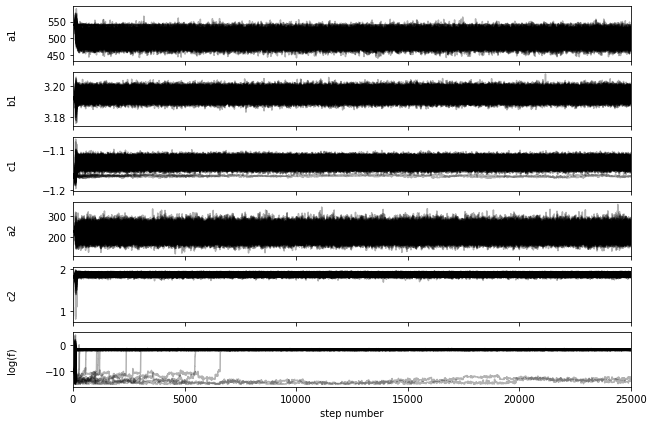

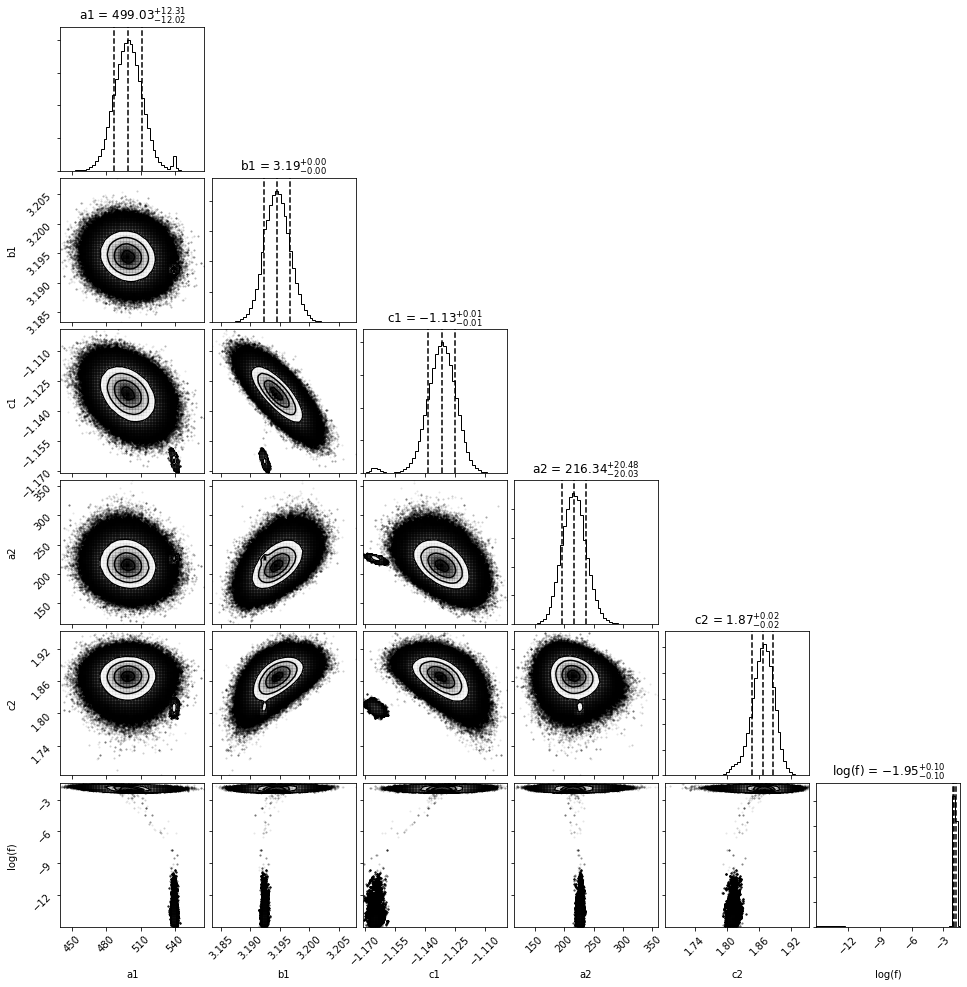

In [26]:
# Let's visualise our chains (a good method to check convergence)

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()  # Retrieve samples
labels = ["a1", "b1", "c1","a2", "c2", "log(f)"]  # Parameter labels

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

# Plot chains, where we're looking for a noisy, stochastic ("hairy caterpiller") output (after burn-in)
flat_samples2 = sampler.get_chain(discard=1000, flat=True)  # Discard the first (burn-in) 1,000 samples 

# Plot the corner plot comparing each parameter over 1 sigma error contours
corner.corner(flat_samples2, labels=labels, quantiles=[0.16,0.5,0.84], show_titles=True, bins=50)

plt.show()

This picture is somewhat more complicated. Unlike for the original model, the MCMC has not found only a global solution, but also a local minimum, most prominent in the c1 parameter (i.e. log of the lognormal standard deviation). It is initially unclear whether some walkers are simply getting stuck in this parameter space or if this is a true minimum. For the purposes of this study however, it does not influence our final model, as the percentiles of interest are well constrained, but it does offer an example of non-conforming MCMC walkers which may be solved sometimes with further iterations (to allow the walkers to escape), or an understanding of a multi-modal parameter space.  

In [27]:
# Let's obtain our parameter solutions from the chains, using our 1 sigma error quantiles, and map these to a function
# which calculates these over our samples:
a1_sol2, b1_sol2, c1_sol2, a2_sol2, c2_sol2, f_sol2 = \
map(lambda v: (v[1],v[2]-v[1],v[1]-v[0]), zip(*np.percentile(flat_samples2,[16,50,84],axis=0)))

mod2_params = a1_sol2[0], b1_sol2[0], c1_sol2[0], a2_sol2[0], c2_sol2[0]  # The model fit parameters

# Which returns the solutions:
print('emcee: ', *mod2_params)

# Which are very similar to the curve_fit solutions (as hoped)
print('curve_fit: ', *popt2)

emcee:  499.0293154835439 3.1944683197529926 -1.1316829976939369 216.33949169169003 1.8672249674016466
curve_fit:  539.4797921262449 3.192363949236238 -1.1651811789986657 226.49763169097682 1.8121909046030686


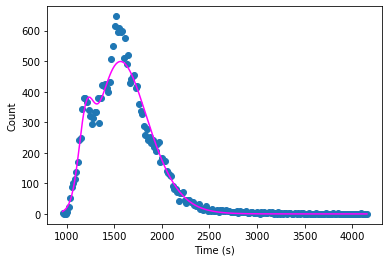

In [28]:
# For confirmation, the new emcee fit looks like this:
plt.scatter(x_parkrun, y_parkrun)
plt.plot(x_parkrun, log_normal_gauss(x_parkrun, *mod2_params), color='magenta')

plt.xlabel('Time (s)')
plt.ylabel('Count')

plt.show()

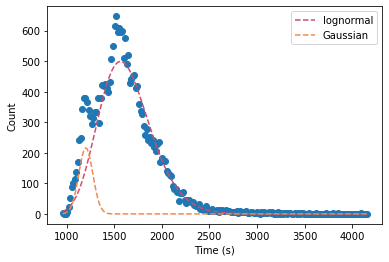

In [55]:
# The individual components of the emcee take the form:
plt.scatter(x_parkrun, y_parkrun)

plt.plot(x_parkrun, log_normal_gauss(x_parkrun, a1_sol2[0], b1_sol2[0], c1_sol2[0], 
                                     0,0), color='#CF4D6F', linestyle='--', label='lognormal')
plt.plot(x_parkrun, log_normal_gauss(x_parkrun, 0,0,0, 
                                     a2_sol2[0], c2_sol2[0]), color='#F08A4B', linestyle='--', label='Gaussian')

plt.xlabel('Time (s)')
plt.ylabel('Count')

plt.legend()

plt.show()

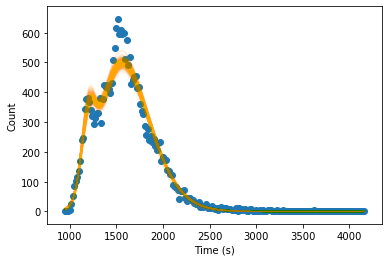

In [30]:
# We can overlay a sample of 1000 chains to show a distribution of model fits:
inds = np.random.randint(len(flat_samples2), size=1000)
for ind in inds:
    sample = flat_samples2[ind]
    plt.plot(x_parkrun, log_normal_gauss(x_parkrun, *sample[:-1]), color='orange', alpha=0.01)
    
    
plt.scatter(x_parkrun, y_parkrun)

plt.xlabel('Time (s)')
plt.ylabel('Count')

plt.show()

In [31]:
# More precisely, we can calculate and show the 1 sigma credible intervals (i.e. 68% probability the true model lies
# within this range) using the results from the MCMC. We have already determined the necessary percentiles:

mod2_upp = a1_sol2[1], b1_sol2[1], c1_sol2[1], a2_sol2[1], c2_sol2[1]  # The [84th percentile - median] parameter values
mod2_low = a1_sol2[2], b1_sol2[2], c1_sol2[2], a2_sol2[2], c2_sol2[2]  # The [median - 16th percentile] parameter values

mod2_uppsig = np.array(mod2_upp) + np.array(mod2_params)  # The +1 sigma parameters (added with np arrays)
mod2_lowsig = np.array(mod2_params) - np.array(mod2_low)  # The -1 sigma parameters

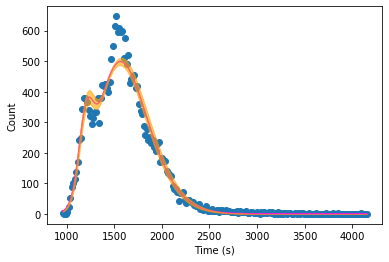

In [32]:
# We can now plot the model output with 68% credible intervals (error contours)

fig, ax = plt.subplots()

ax.scatter(x_parkrun, y_parkrun)

ax.fill_between(x_parkrun, log_normal_gauss(x_parkrun, *mod2_uppsig), log_normal_gauss(x_parkrun, *mod2_lowsig), 
                color='orange', zorder=3, alpha=0.6)  # Input the +1/-1 sigma parameters

ax.plot(x_parkrun, log_normal_gauss(x_parkrun, *mod2_params), color='magenta')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Count')

plt.show()

So we have taken our basic model and obtained a best fit and error ranges with emcee. We can see however that this model is limited in scope in describing the underlying distribution of the data. The next step is to introduce another more complex model, perform the same procedural tests and then compare the models statistically.

## Lognormal + Gaussian + Gaussian model

The nature of these sample data is still more complex than either model introduced thus far. In addition to the 20 minute peak is a small 'shoulder' in the data at ~1900 seconds and a non-symmetric primary peak. The primary peak is likely not being well modelled as the lognormal fit to the tail of the distribution is so effective. If we now introduce a Gaussian component to describe the primary peak (centred ~26mins), we can then let the lognormal better describe the shoulder and tail of the distribution.

So, let's introduce a secondary Gaussian component into the model, and follow the procedure again.

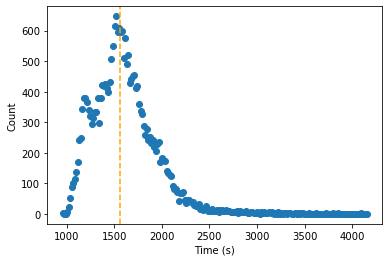

In [54]:
# We need to better account for the main peak of the distribution which occurs around ~1560 seconds (~26mins)
plt.xlabel('Time (s)')
plt.ylabel('Count')

plt.scatter(x_parkrun , y_parkrun)

# Plot a line at a 26 min 5k
plt.axvline(60*26, color='orange', linestyle='--')

plt.show()

In [34]:
# Let's create a more complex model which combines the original lognormal with TWO additional Gaussian distributions
# defined with a frozen paramerers b2 = 1200 and b3 = 1560 (i.e. fixed and centred on 20 mins, 26mins) 

def log_normal_two_gauss(x, a1, b1, c1, a2, c2, a3, c3):
    """Returns lognormal distribution + Gaussian distribution, mean = 1200"""
    G = a1*np.exp( -(np.log10(x)-b1)**2  / (2*(10**c1)**2) ) + a2*np.exp( -(x-1200)**2  / (2*(10**c2)**2) ) \
    + a3*np.exp( -(x-1560)**2  / (2*(10**c3)**2) )
    return G

In [35]:
# Let's implement this new model as before using scipy curve_fit and some well chosen initial parameters
popt3, pcov3 = curve_fit(log_normal_two_gauss, x_parkrun, y_parkrun, p0=[300,3,-1,100,0.1,80,1], sigma=yerr_parkrun)

# Print optimised parameters a1, b1, c1, a2, c2, a3, c3
print(popt3)

[448.57380758   3.18912146  -1.09779396 191.9707793    1.77371386
 158.89828405   1.86709457]


/Users/dia1u17/opt/anaconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in double_scalars
  import sys


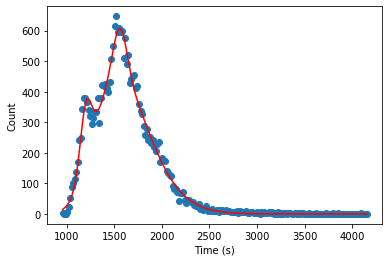

In [36]:
# The best fit with this further revised model using curve_fit looks like this:
plt.scatter(x_parkrun, y_parkrun)
plt.plot(x_parkrun, log_normal_two_gauss(x_parkrun, *popt3), color='red')

plt.xlabel('Time (s)')
plt.ylabel('Count')

plt.show()

Which now appears to be a major improvement! We will evaluated this statistically in the next section.

As before, let's implement an MCMC routine through emcee to do show some more advanced metrics.

In [37]:
# Let's our emcee functions again: likelihood, prior and log_probaility, as adapted from the emcee docs
# For a lognormal distribution + Gaussian1 (fixed mean) + Gaussian2 (fixed mean)

def log_likelihood3(theta, x, y, yerr):
    "Function returns the log likelihood: log[p(x|theta)]"
    
    a1, b1, c1, a2, c2, a3, c3, log_f = theta
    model = log_normal_two_gauss(x, a1, b1, c1, a2, c2, a3, c3)
    sigma2 = yerr**2 + model**2*np.exp(2*log_f)
    
    return -0.5*np.sum((y-model)**2/sigma2 + np.log(sigma2))

def log_prior3(theta):
    "Function defining the priors: p(theta)"
    
    a1, b1, c1, a2, c2, a3, c3, log_f = theta
    if 20 < a1 < 1000 and 2.5 < b1 < 4 and -3 < c1 < 1 and 20 < a2 < 1000 and -1 < c2 < 3 \
    and 20 < a2 < 1000 and -1 < c2 < 3 and -15 < log_f < 10:      
        return 0.0
    
    return -np.inf

def log_probability3(theta, x, y, yerr):
    "Function returning the log probability: log[p(theta|x)]"
    
    lp = log_prior3(theta)
    if not np.isfinite(lp):
        return -np.inf
    
    return lp + log_likelihood3(theta, x, y, yerr)


In [38]:
# Let's set up the new MCMC sampler in emcee and then launch it

nwalkers, ndim = 200, 8  # Define a number of walkers (200) and number of dimensions (8: a1, b1, c1, a2, c2, a3, c3 & log(f))

p0 = np.array([*popt3,-10])  # Use curve_fit parameters as starting positions
pos = p0 + 1e-4*np.random.randn(nwalkers,ndim)  # Randomise starting position of walkers

# Now define the MCMC sampler, using the defined log_probability function and data as arguments
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability3, args=(x_parkrun, y_parkrun, yerr_parkrun))

# Set the number of steps to be 10,000 and run the MCMC (takes ~few minutes)
sampler.run_mcmc(pos, 10000, progress=True)

100%|██████████| 10000/10000 [02:20<00:00, 71.05it/s]


State([[386.58599888   3.20056112  -1.11958845 ... 186.93378431   2.0801988
   -2.10306929]
 [427.07510333   3.20078945  -1.13128782 ... 208.82268003   1.87390475
   -2.23204351]
 [440.23852763   3.20191694  -1.13908419 ... 168.93804949   1.89932712
   -2.18008   ]
 ...
 [399.2084899    3.19987753  -1.12065299 ... 185.82757674   2.05633167
   -2.14495107]
 [414.25330698   3.19909122  -1.12367924 ... 169.17355115   2.03216931
   -2.2168127 ]
 [426.57230664   3.19756115  -1.1185965  ... 172.38091287   1.90932411
   -2.19270457]], log_prob=[ -539.47613812  -541.51316054  -542.36479636  -538.22268218
  -540.18551163  -538.2712474   -541.86940044  -540.79425739
  -542.2428997   -540.23218285  -544.3768416   -541.72040655
  -541.04707113  -539.15061165  -538.37967989  -545.50377184
  -541.60867989  -541.7481841   -541.54013451  -540.7615242
  -539.46177855  -541.64435062  -540.63365953  -540.78020251
  -540.80394521  -543.44512521  -538.73650298  -543.94691778
  -537.90539274  -539.54988199 

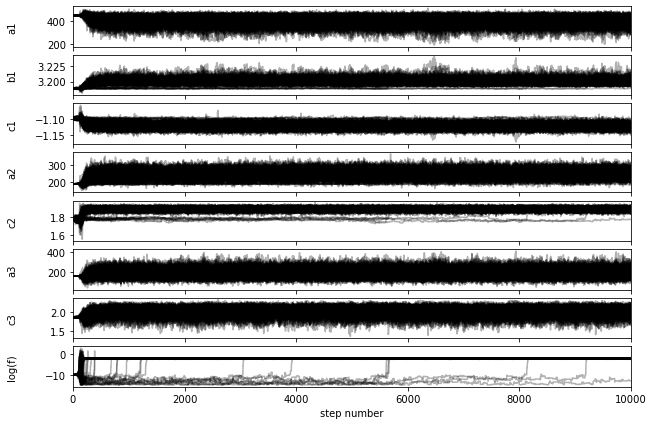

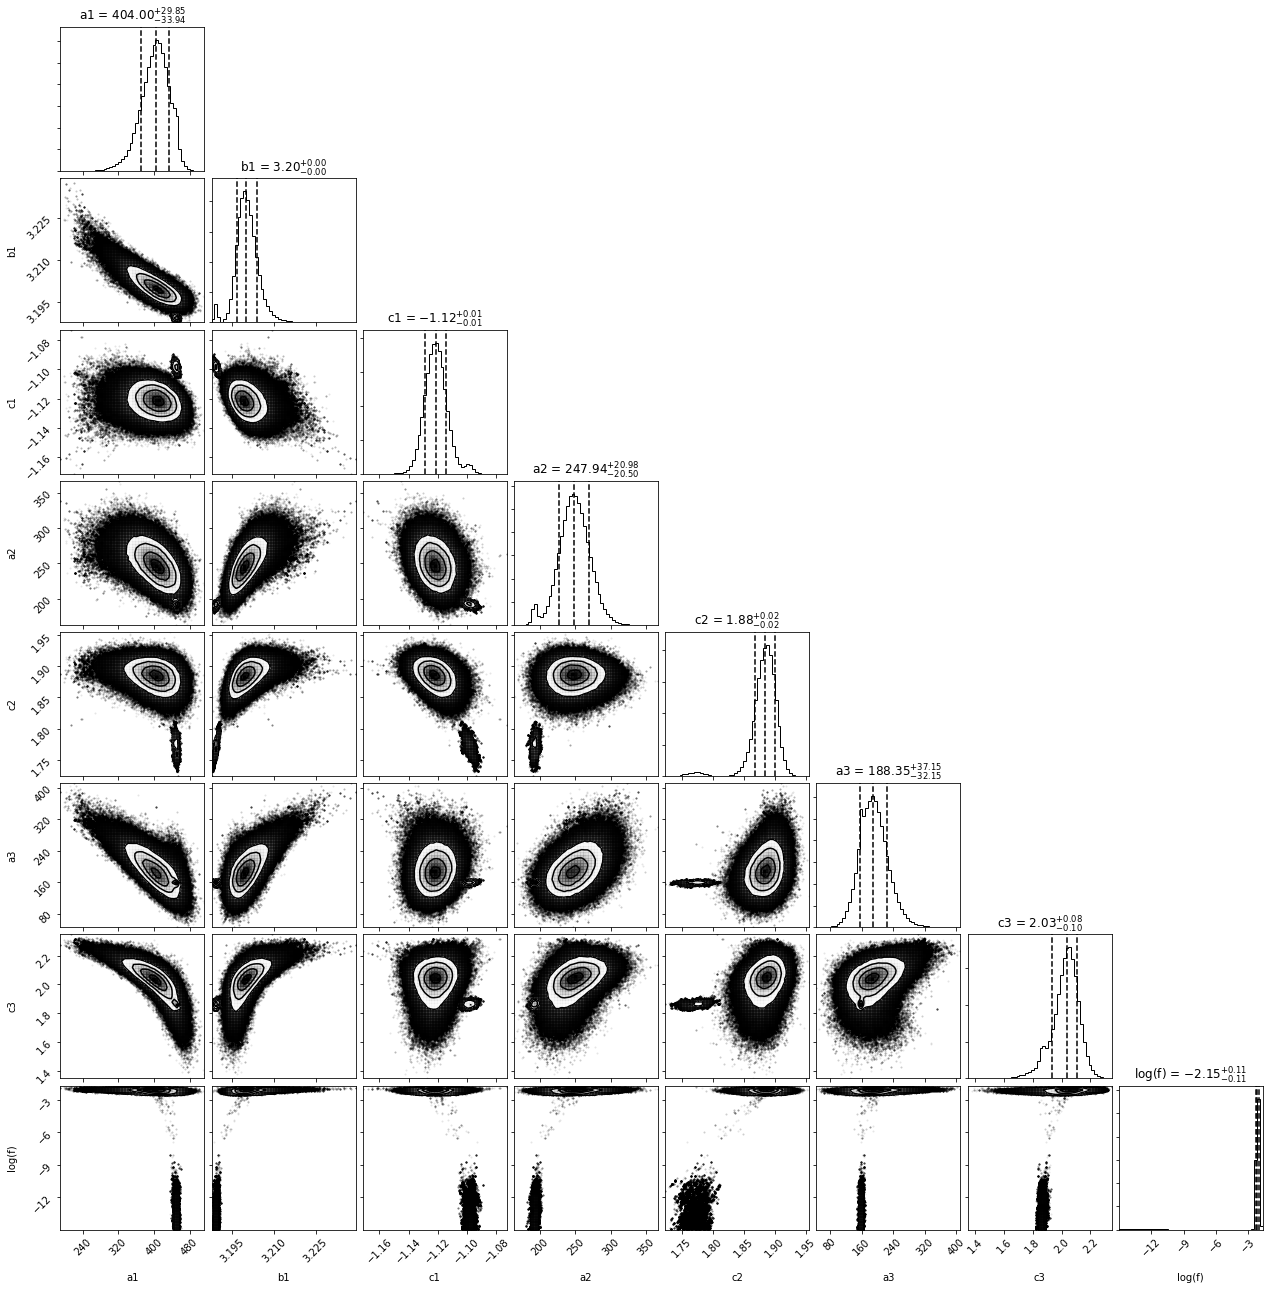

In [39]:
# Let's visualise our chains (a good method to check convergence)

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()  # Retrieve samples
labels = ["a1", "b1", "c1", "a2", "c2", "a3", "c3", "log(f)"]  # Parameter labels

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

# Plot chains, where we're looking for a noisy, stochastic ("hairy caterpiller") output (after burn-in)
flat_samples3 = sampler.get_chain(discard=1000, flat=True)  # Discard the first (burn-in) 1,000 samples 

# Plot the corner plot comparing each parameter over 1 sigma error contours
corner.corner(flat_samples3, labels=labels,quantiles=[0.16,0.5,0.84], show_titles=True, bins=50)

plt.show()

This is again a more complicated picture. There appear to be local minima present (predominantly) in the c1 and c2 parameters, corresponding to standard deviation of the lognormal, and first Gaussian, components. As before, this can be a concern as to the nature of these secondary minima. Further study may show these features to be artificially induced by stuck walkers or indeed actual signs of multi-modal parameter space. For the purposes of this study, the primary results are again not overly influenced, as parameter distributions remain well contrained, so we continue with these outputs.

In [40]:
# Let's obtain our parameter solutions from the chains, using our 1 sigma error quantiles, and map these to a function
# which calculates these over our samples:
a1_sol3, b1_sol3, c1_sol3, a2_sol3, c2_sol3, a3_sol3, c3_sol3, f_sol3 = \
map(lambda v: (v[1],v[2]-v[1],v[1]-v[0]), zip(*np.percentile(flat_samples3,[16,50,84],axis=0)))

mod3_params = a1_sol3[0], b1_sol3[0], c1_sol3[0], a2_sol3[0], c2_sol3[0], a3_sol3[0], c3_sol3[0]

# Which returns the solutions:
print('emcee: ', *mod3_params)

# Which are beginning to deviate further from the curve_fit solutions
print('curve_fit: ', *popt3)

emcee:  404.0017959373127 3.1999620374854176 -1.1216299917033177 247.937965646118 1.8845717229254877 188.35129875810725 2.0337701038094838
curve_fit:  448.5738075838234 3.189121463827426 -1.0977939565168282 191.97077930112593 1.7737138633177085 158.8982840484945 1.86709457004724


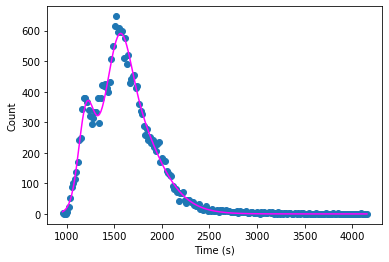

In [41]:
# For confirmation, the new emcee fit looks like this:
plt.scatter(x_parkrun, y_parkrun)
plt.plot(x_parkrun, log_normal_two_gauss(x_parkrun, *mod3_params), color='magenta')

plt.xlabel('Time (s)')
plt.ylabel('Count')

plt.show()

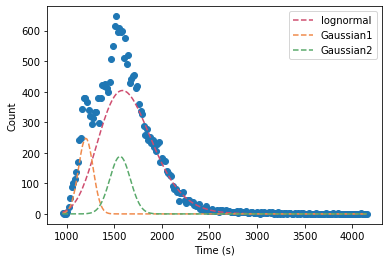

In [56]:
# The individual components of the emcee take the form:
plt.scatter(x_parkrun, y_parkrun)

plt.plot(x_parkrun, log_normal_two_gauss(x_parkrun, a1_sol3[0], b1_sol3[0], c1_sol3[0],
                                         0,0,0,0), color='#CF4D6F', linestyle='--', label='lognormal')
plt.plot(x_parkrun, log_normal_two_gauss(x_parkrun, 0,0,0,
                                         a2_sol3[0], c2_sol3[0], 0,0), color='#F08A4B', linestyle='--', label='Gaussian1')
plt.plot(x_parkrun, log_normal_two_gauss(x_parkrun, 0,0,0,0,0,
                                        a3_sol3[0], c3_sol3[0]), color='#59A96A', linestyle='--', label='Gaussian2')

plt.xlabel('Time (s)')
plt.ylabel('Count')

plt.legend()

plt.show()

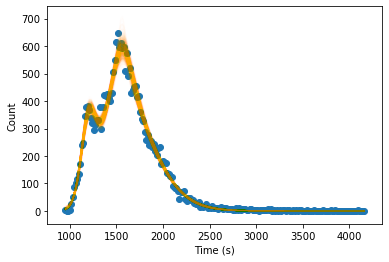

In [43]:
# Let's show a random sample of 1,000 model fits from the MCMC chain
inds = np.random.randint(len(flat_samples3), size=1000)
for ind in inds:
    sample = flat_samples3[ind]
    plt.plot(x_parkrun, log_normal_two_gauss(x_parkrun, *sample[:-1]), color='orange', alpha=0.01)
    
plt.scatter(x_parkrun, y_parkrun)

plt.xlabel('Time (s)')
plt.ylabel('Count')

plt.show()

In [44]:
# More precisely, we can calculate and show the 1 sigma credible intervals (i.e. 68% probability the true model lies
# within this range) using the results from the MCMC. We have already determined the necessary percentiles:

mod3_upp = a1_sol3[1], b1_sol3[1], c1_sol3[1], a2_sol3[1], c2_sol3[1], a3_sol3[1], c3_sol3[1]  # The [84th percentile - median] parameter values
mod3_low = a1_sol3[2], b1_sol3[2], c1_sol3[2], a2_sol3[2], c2_sol3[2], a3_sol3[2], c3_sol3[2]  # The [median - 16th percentile] parameter values

mod3_uppsig = np.array(mod3_upp) + np.array(mod3_params)  # The +1 sigma parameters (added with np arrays)
mod3_lowsig = np.array(mod3_params) - np.array(mod3_low)  # The -1 sigma parameters

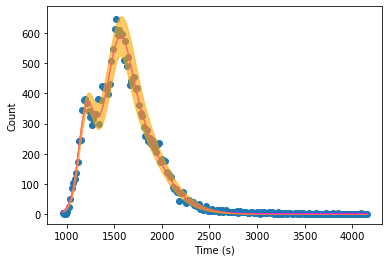

In [45]:
# We can now plot the model output with 68% credible intervals (error contours)

fig, ax = plt.subplots()

ax.scatter(x_parkrun, y_parkrun)

ax.fill_between(x_parkrun, log_normal_two_gauss(x_parkrun, *mod3_uppsig), log_normal_two_gauss(x_parkrun, *mod3_lowsig), 
                color='orange', zorder=3, alpha=0.6)  # Input the +1/-1 sigma parameters

ax.plot(x_parkrun, log_normal_two_gauss(x_parkrun, *mod3_params), color='magenta')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Count')

plt.show()

Excellent! This model is sufficiently complex to well describe the data, within error ranges. 

An obvious question now may be: "why not introduce yet another additional component?" Why stop here? With added model complexity comes the risk of overfitting our data, and trying to fit model components to purely stochastic noise. There isn't a silver bullet to determine exactly when this line is crossed, but there are practices we can use to attempt to quantify model selection statistically. 

## Model Selection

Bayesian model selection is a non-trivial business. There are numerous methodologies available to achieve this, with a range of complexity and computational demands. 

Here, I'm going to turn to one of the most well known, and simple, information criterion tests: the Akaike information criterion (AIC). This is slightly undisciplined in the sense that the AIC is a purely frequentist test which here is being applied to a broadly Bayesian problem. It does serve a useful purpose here however of being a quick and easy test which favours improved model fits to data (increased likelihood) but penalises additional model components. The best model choice is then that which minimises the AIC value.

In [46]:
def AIC(k, logL):
    "Returns the Akaike information criterion (k model params, log(likelihood))"
    return 2*k - 2*logL

In [47]:
# Let's implement the AIC test, by taking the maximum likelihood model parameters (theta) for each model (1, 2, 3)
# and calculating the above function. Model 1 has k=3, Model 2 has k=5 and Model 3 has k=7.

theta1 = *mod1_params, f_sol[0]  # Max like parameters for model 1
logL1 = log_probability(theta1, x_parkrun, y_parkrun, yerr_parkrun)  # Log probability for model 1

theta2 = *mod2_params, f_sol2[0]
logL2 = log_probability2(theta2, x_parkrun, y_parkrun, yerr_parkrun)

theta3 = *mod3_params, f_sol3[0]
logL3 = log_probability3(theta3, x_parkrun, y_parkrun, yerr_parkrun)

aic1, aic2, aic3 = AIC(3, logL1), AIC(5, logL2), AIC(7, logL3)  # Calculate the AIC for all models

print('Model 1: ', aic1, '  Model 2: ', aic2, '  Model 3: ', aic3)  # Print the results

Info_crit = np.array([aic1, aic2, aic3])

Model_choice = 'Model {}'.format(np.argmin(Info_crit)+1)  # Selects the minimised model

print('AIC minimised for: ', Model_choice)

Model 1:  1199.696721509396   Model 2:  1121.4099576429214   Model 3:  1088.0769086375594
AIC minimised for:  Model 3


From this we confirm that Model 3 (lognormal + Gaussian + Gaussian) is the statistically favoured choice. 

In the hypothetical case of a more complex model which doesn't improve the likelihood, p(x|theta), with an increased number of components, the AIC value would then increase and this model would not be deemed an improvement.

# Club Training

With a chosen model which best decribes our sample data, we have a model which thus describes our club population under our original assumptions. Following our original aim, we will split this model into even sized groups and evaluate the time boundaries which correspond to these dividing lines. 

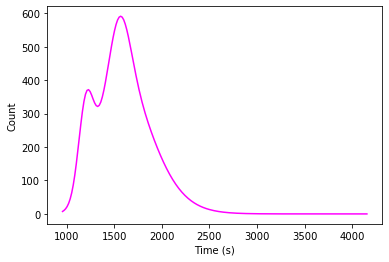

In [48]:
# Let's review our best model:
plt.plot(x_parkrun, log_normal_two_gauss(x_parkrun, *mod3_params), color='magenta')

plt.xlabel('Time (s)')
plt.ylabel('Count')

plt.show()

In [57]:
x_parkrun

array([ 955.0425,  971.1275,  987.2125, 1003.2975, 1019.3825, 1035.4675,
       1051.5525, 1067.6375, 1083.7225, 1099.8075, 1115.8925, 1131.9775,
       1148.0625, 1164.1475, 1180.2325, 1196.3175, 1212.4025, 1228.4875,
       1244.5725, 1260.6575, 1276.7425, 1292.8275, 1308.9125, 1324.9975,
       1341.0825, 1357.1675, 1373.2525, 1389.3375, 1405.4225, 1421.5075,
       1437.5925, 1453.6775, 1469.7625, 1485.8475, 1501.9325, 1518.0175,
       1534.1025, 1550.1875, 1566.2725, 1582.3575, 1598.4425, 1614.5275,
       1630.6125, 1646.6975, 1662.7825, 1678.8675, 1694.9525, 1711.0375,
       1727.1225, 1743.2075, 1759.2925, 1775.3775, 1791.4625, 1807.5475,
       1823.6325, 1839.7175, 1855.8025, 1871.8875, 1887.9725, 1904.0575,
       1920.1425, 1936.2275, 1952.3125, 1968.3975, 1984.4825, 2000.5675,
       2016.6525, 2032.7375, 2048.8225, 2064.9075, 2080.9925, 2097.0775,
       2113.1625, 2129.2475, 2145.3325, 2161.4175, 2177.5025, 2193.5875,
       2209.6725, 2225.7575, 2241.8425, 2257.9275, 

In [60]:
# Our goal now is to integrate under this model to determine its area (and thus assign equal sized groups).
# We can do with the quad function from the scipy.integrate library

low_lim, upp_lim = x_parkrun[0], x_parkrun[-1]  # Find the lower and upper limits of our integration

Integral = quad(log_normal_two_gauss, low_lim, upp_lim, args=(mod3_params))  # Integrate under the model

print(Integral)  # Returns (integral calculation, error)

(381879.73617429787, 0.0006937580837984569)


We can now implement this method to achieve our aim of restructuring group sizes.

For a defined number of training groups (here, num_groups=7), we step through this integration and find the time (to the nearest second) which corresponds with the dividing line between groups. This is achieved through the function below.

In [50]:
def time_calc(low_lim, num_groups, Integral):
    """Calculates integral of a function iteratively and returns n number of x values (times) at the normalised
    n/num_groups dividing lines"""
    
    time = int(low_lim)  # Start from the lower limit
    model_times = []
    I = 0
    
    for grp in range(num_groups):  # For each group
        
        int_target = (grp+1)/num_groups  # The normalised target fraction (n/num_groups) 
    
        while I < int_target:
            time += 1  # Iterate over individual seconds
            # Calculate normalised integral, bounded by lower limit and updated time:
            I = quad(log_normal_two_gauss, low_lim, time, args=(mod3_params))[0] / Integral[0]  
            # When this exceeds int_target, break loop

        model_times.append(time) # Record this time   
        
    return model_times

model_times = time_calc(low_lim, 7, Integral)  # Input our lower limit, 7 groups and integral of our model
                                               # Return the dividing line times 

In [51]:
# With this calculation complete, let's print these result out

Groups = ['A', 'B', 'C', 'D', 'E', 'F', 'G']  # Our (7) group names (ranked from slowest - fastest)
time_boundaries = [low_lim] + model_times  # Gather the time boundaries with the lower limit

def group_writeout(Group_names, times):
    for i,name in enumerate(Group_names[::-1]):  # Reorder group names (start with fastest group)
        time_low, time_upp = secs_mins(times[i]), secs_mins(times[i+1])  # Convert seconds to minutes
        print('{0} < Group {1} < {2}'.format(time_low[:-2], name, time_upp[:-2]))  # Output these values to nearest second
        
group_writeout(Groups, time_boundaries)

15:55 < Group G < 20:55
20:55 < Group F < 23:34
23:34 < Group E < 25:24
25:24 < Group D < 26:57
26:57 < Group C < 28:48
28:48 < Group B < 31:41
31:41 < Group A < 69:16


And so now we have our model defined group boundaries.

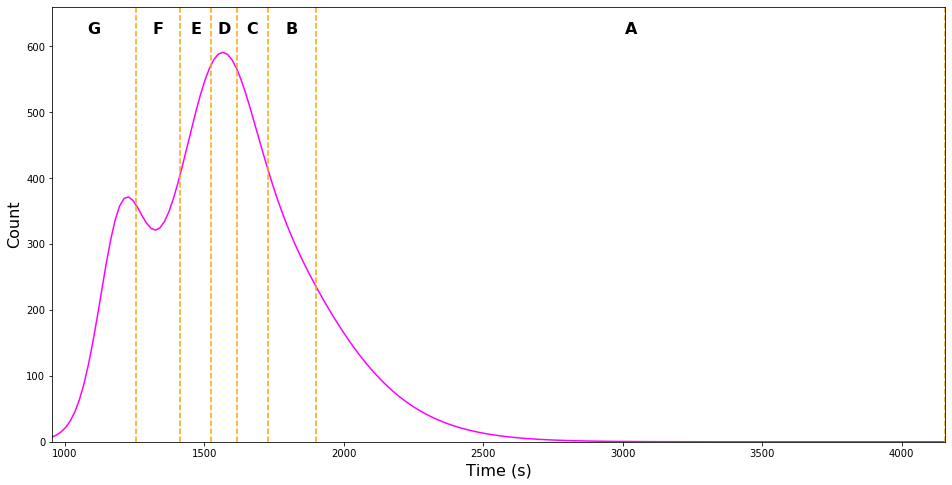

In [52]:
# Let's now plot these results to visualise this information

plt.figure(figsize=(16,8))

plt.ylim(0,660)
plt.plot(x_parkrun, log_normal_two_gauss(x_parkrun, *mod3_params), color='magenta')

for i,divide_line in enumerate(model_times):
    plt.axvline(divide_line, linestyle='--', color='orange')  # Plot on our dividing lines
    
    # Add group name in between dividing lines    
    plt.text( time_boundaries[i]+(time_boundaries[i+1]-time_boundaries[i])/2 , 620, Groups[::-1][i], 
             ha='center', fontsize=16, weight='bold')

plt.xlim(low_lim, upp_lim)  # Set x limits to low/upp boundaries
    
plt.xlabel('Time (s)', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.show()

# Summary

In summary, we have created a model which describes the underlying population of the club using 5k times from parkrun. From this we have determined the ideal time boundaries for the training groups, from 'Group A' through to the fastest runners in 'Group G'.

The complication with using these results to adjust or even overhaul club training group structure in in some of our initial assumptions. Each group may not necessarily be designed to be equal in size, indeed the fastest group, i.e. Group G in this case, is considered a smaller, elite group. 

This work does however offer a data-driven insight into the nature of 5k performance across the club and the potential for this to drive future decisions.